# Homework 08 — IANNwTF
## Group 27
Deadline: Dec 19, 2021 23:59

<https://forms.gle/n6ERdhYx3uBPzuGn9>

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Dataset

In [21]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [22]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


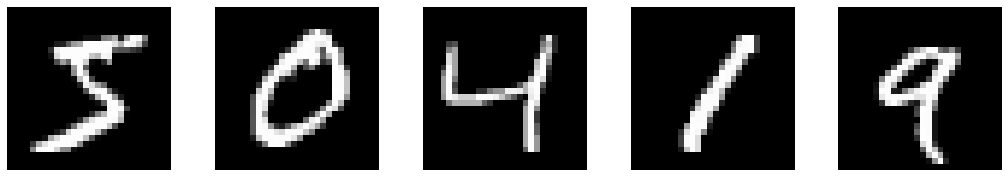

In [23]:
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(18,3))
ax = ax.ravel()
for i in range(npics):
  ax[i].imshow(X_train[i], cmap='gray')
  ax[i].axis("off")

In [24]:
# Load the dataset and construct a tf.Data.Dateset for testing and training using the images only
train_ds = tf.data.Dataset.from_tensor_slices(X_train)
test_ds = tf.data.Dataset.from_tensor_slices(X_test)

In [25]:
def prepare_data(ds, target_ds=False):
  # convert data from uint8 to float32
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))

  # bring image values from range [0, 255] to [0, 1]
  ds = ds.map(lambda img: (img/255.))

  # add third dimension
  ds = ds.map(lambda img: tf.expand_dims(img, axis=-1))

  if target_ds == False:
    # Add noise to the images
    how_noisy = 0.2 # std deviation of the normal distribution
    ds = ds.map(lambda img: tf.add(img, tf.random.normal(shape=(28,28,1), mean=0.0, stddev=how_noisy, dtype=tf.dtypes.float32)))

    # make sure the images are kept in the range [0,1]
    ds = ds.map(lambda img: tf.clip_by_value(img, 0, 1))

  # shuffle, batch, prefetch
  ds = ds.shuffle(1000).batch(32).prefetch(20)
  return ds

In [26]:
train_inputs_ds = prepare_data(train_ds)
test_inputs_ds = prepare_data(test_ds)
train_targets_ds = prepare_data(train_ds, target_ds=True)
test_targets_ds = prepare_data(test_ds, target_ds=True)

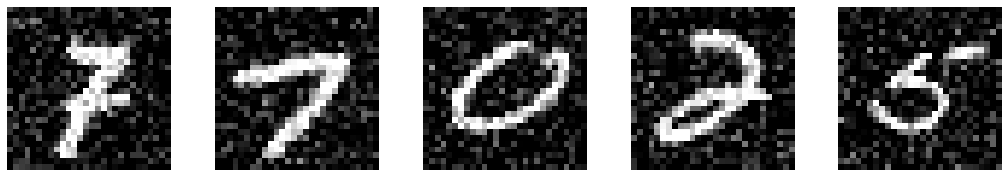

In [27]:
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(18,3))
ax = ax.ravel()
for elem, i in zip(train_inputs_ds.take(npics), range(npics)):
  ax[i].imshow(tf.squeeze(elem).numpy()[0], cmap='gray')
  ax[i].axis("off")

# Model: Convolutional Autoencoder

In [28]:
class Encoder(tf.keras.Model):
  def __init__(self, embedding_size=10):
    super(Encoder, self).__init__()
    self.layers_list = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', input_shape=((28,28,1))),
                        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(embedding_size)]
  
  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)
    return x


In [29]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layers_list = [tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
                        tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                        tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')] # output layer
  
  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)
    return x
    

In [30]:
class Autoencoder(tf.keras.Model):
  def __init__(self, embedding_size=10):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(embedding_size)
    self.decoder = Decoder()
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
    

# Training

In [31]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric):
    # training step
    with tf.GradientTape() as tape:
      predictions = model(inputs)
      loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric):
    # test step
    predictions = model(inputs)
    loss = loss_fn(targets, predictions)
    logs = {}
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs, predictions

In [32]:
tf.keras.backend.clear_session()

# Hyperparameters
epochs = 10
learning_rate = 0.001

# Initialize the model
model = Autoencoder()

# Initialize the loss function: categorical cross entropy
loss_fn = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'val_loss': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

examples = {"prediction": [], "target": []}

# training
for epoch in range(epochs):
    reset_metrics([loss_metric])
    for inputs, targets in zip(train_inputs_ds, train_targets_ds):
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

    # test
    reset_metrics([loss_metric])
    for inputs_batch, targets_batch in zip(test_inputs_ds, test_targets_ds):
        logs, predictions = test_step(inputs_batch, targets_batch, loss_fn, loss_metric)
    examples["prediction"].append(predictions[0])
    examples["target"].append(targets_batch[0])
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")


Results at the end of epoch 0
...loss: 0.0686
...Evaluation results:
...val_loss: 0.0682
Results at the end of epoch 1
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0681
Results at the end of epoch 2
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0681
Results at the end of epoch 3
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0679
Results at the end of epoch 4
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0679
Results at the end of epoch 5
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0679
Results at the end of epoch 6
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0679
Results at the end of epoch 7
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0678
Results at the end of epoch 8
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0679
Results at the end of epoch 9
...loss: 0.0673
...Evaluation results:
...val_loss: 0.0677


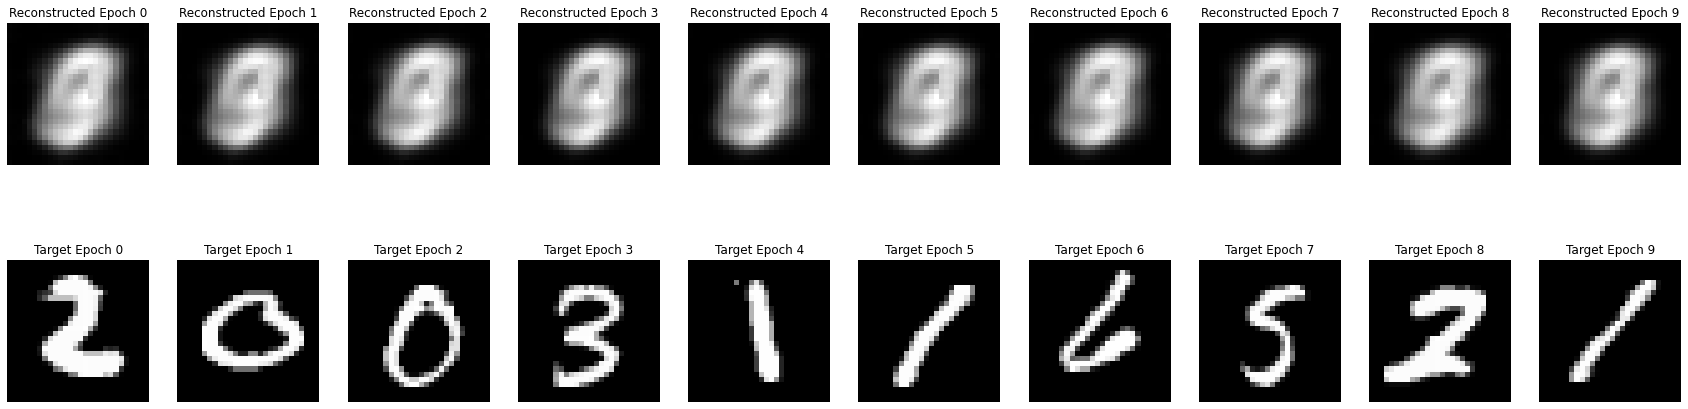

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=epochs, figsize=(30,8))
ax = ax.ravel()
for i, prediction in enumerate(examples["prediction"]):
  ax[i].imshow(tf.squeeze(prediction).numpy(), cmap='gray')
  ax[i].set_title("Reconstructed Epoch {}".format(i))  
  ax[i].axis("off")

for i, target in enumerate(examples["target"]):
  ax[epochs+i].imshow(tf.squeeze(target).numpy(), cmap='gray')
  ax[epochs+i].set_title("Target Epoch {}".format(i))  
  ax[epochs+i].axis("off")


# Latent Space Analysis